#### Alumno: 
*Alejandro Pérez Sanjuán*

#### Comentarios:
* No estoy en ningún grupo, así que no he puesto integrantes.
* Las funciones se han comentado utilizando [numpy style guide](https://numpydoc.readthedocs.io/en/latest/format.html).
* Las referencias se encuentran correspondientemente mencionadas en la sección `References` de cada función.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy import ndimage
from sklearn.decomposition import PCA
from sklearn.datasets import load_sample_images
from skimage.metrics import peak_signal_noise_ratio
from skimage.data import astronaut, coffee, cat, rocket

## Datos
Se han utilizado distintas imágenes, tanto de Sklearn como de Skimage. A lo largo del documento se pueden ver cuáles han sido las imágenes

In [2]:
dataset = load_sample_images()
building, flower = dataset['images'][0], dataset['images'][1]

## Anomalía a eliminar
En este documento se ha escogido eliminar un ruido gaussiano. Para crear las imágenes *ensuciadas* se dibujan datos de una distribución normal

$$
s_{k} \sim \mathcal{N}(\mu, \sigma)
$$

y se suman a la imagen original para crear el ruido. El método `add_noise` realiza este procedimiento. Nótese el casteo a **unsigned integer** para evitar errores en la visualización de los datos. Si el intervalo es 0-255, `imshow` espera un tipo de datos entero.

In [3]:
def add_noise(img, mean=0, std=1, cast=True):
    """Add gaussian noise to a given image to create a noisy
    image.
    
    Parameters
    ----------
    img : numpy.array
        Image to add noise to.
    mean : int or float
        Mean of the gaussian noise.
    std : int or float
        Standard deviation of the gaussian noise.
    
    References
    ----------
    .. [1] StackOverflow - Why does adding Gaussian noise to image give white screen?
       https://stackoverflow.com/questions/50641860/why-does-adding-gaussian-noise-to-image-give-white-screen
    """
    noisy_img = np.clip(img + np.random.normal(mean, std, img.shape), 0, 255)
    
    if cast:
        noisy_img = noisy_img.astype('uint8') # cast to unsigned integer. See references
    
    return noisy_img

## Eliminación de ruido: PCA + Gaussian denoising

### PCA
En PCA se intenta aproximar la matriz de datos original a través de una combinación lineal de sus componenetes principales, extraidas de los valores propios de la matriz de covarianza de los datos.

Tras obtener los componentes, aplicar una transformación inversa devolvería los datos originales reconstruidos a partir de una varianza menor. Es a partir de la reducción de esta varianza donde se espera también reducir el ruido.


###  Gaussian denoising

Este método genera un kernel Gaussiano en función del valor o valores de sigma y lo multiplica deslizándolo por la matriz de datos, sustituyendo el píxel central por el resultado. Esto es, `gaussian denoising` no es más que una convolución.

In [4]:
def pca_denoising(img, n_components):
    """Denoise a given image using PCA.
    
    Parameters
    ----------
    img : numpy.array
        Image to denoise.
    n_components : int
        Number of components in the PCA.
    
    Returns
    -------
    clipped : numpy.array
        Denoised image.
    
    References
    ----------
    .. [1] StackOverflow - PCA of RGB Image
       https://stackoverflow.com/questions/22533392/pca-of-rgb-image
    """
    # the number of components is given, but it should always be the max. number possible
    pca = PCA(n_components).fit(img.reshape(-1,3))
    
    # transformed data. a.k.a: we project the data into the axis to create the linear comb.
    transformed = pca.fit_transform(img.reshape(-1,3))
    
    # inverse to reconstruct the original data and, hopefully, remove some noise
    inv_transform = pca.inverse_transform(transformed)
    
    # clip to 0-255 and cast to unsigned integer. Also. we retrieve the original shape
    return np.clip(inv_transform.reshape(img.shape), 0, 255).astype('uint8')


def denoise_image(img, sigma=0.7, pca_components=3):
    """
    Denoise a given image using gaussian filter and PCA.
    
    Parameters
    ----------
    noisy : numpy.array
        Image to denoise. Image should be RGB: 3 dimensions with the
        last dimension being 3.
    sigma : int or float, optional, default: 0.7
        Variance of the gaussian distribution.
    pca_components : int, optional, default: 3
        Number of components in the PCA.
    
    Returns
    -------
    denoised : numpy.array
        Denoised image with original shape.
    
    References
    ----------
    .. [1] Apeer_micro - Gaussian denoising for noise reduction
        https://www.youtube.com/watch?v=g-1bTTNOZa0&list=
        PLHae9ggVvqPgyRQQOtENr6hK0m1UquGaG&index=34&ab_channel=Apeer_micro
    """
    if img.shape[-1] != 3:
        raise ValueError("Is not possible to apply this technique in a non-rgb image")
        
    # step 1: pca denoising
    pca_denoised = pca_denoising(img=img, n_components=pca_components)
    
    # step 2: gaussian filter
    return ndimage.gaussian_filter(pca_denoised, sigma=sigma)

## Resultados
Para medir la bondad de los resultados se ha utilizado el `peak signal to noise ratio`, que viene implementado en skimage. En este caso, es una medida robusta porque las imágenes limpiadas tienen el mismo codec y son la misma imagen (según [wikipedia](https://en.wikipedia.org/wiki/Peak_signal-to-noise_ratio)).

Los resultados muestran un aumento en el `peak signal to noise ratio` de la imagen procesada respecto de la imagen con ruido, indicando que el método es capaz de limpiar una parte de la anomalía.

In [5]:
def plot_results(imgs):
    """Plot the original, noisy and denoised image.
    
    Parameters
    ----------
    imgs : list
        List of images to get the results from.
    """
    for im in imgs:
        fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 10))

        # get noisy image
        noisy = add_noise(im, mean=1, std=22)
        noisy_psnr = peak_signal_noise_ratio(image_true=im, image_test=noisy)

        # denoised image
        denoised = denoise_image(noisy, sigma=0.545, pca_components=3)
        denoised_psnr = peak_signal_noise_ratio(image_true=im, image_test=denoised)

        ax[0].imshow(im)
        ax[0].set_title('Original')
        ax[0].set_xlabel("Original psnr: inf")

        ax[1].imshow(noisy)
        ax[1].set_title('Noisy')
        ax[1].set_xlabel(f"Noisy psnr: {noisy_psnr:.2f}")

        ax[2].imshow(denoised)
        ax[2].set_title('Denoised')
        ax[2].set_xlabel(f"Denoised psnr: {denoised_psnr:.2f}")

        plt.show()

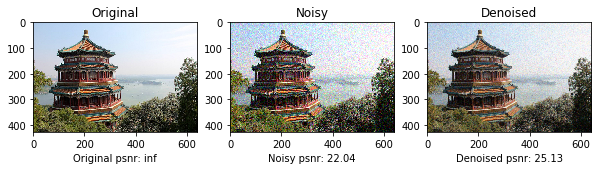

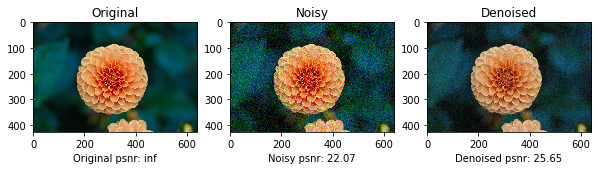

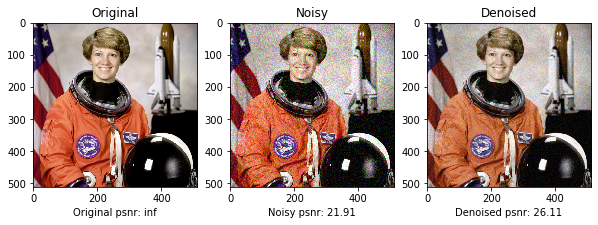

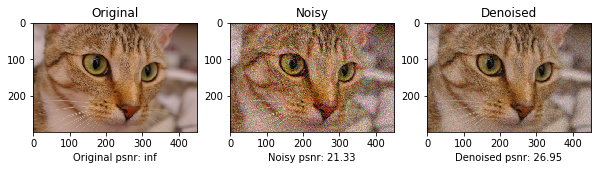

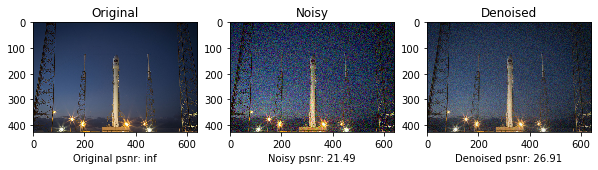

In [6]:
imgs = [building, flower, astronaut(), cat(), rocket()]
plot_results(imgs=imgs)

## Conclusiones
En este documento se ha presentado una combinación de dos técnicas conocidas para eliminar el ruido. El algoritmo es simple y no requiere de un conjunto de datos, puesto que no hay parámetros que optimizar.

Se ha observado que el procedimiento es potencialmente aplicable a cualquier imagen RGB incluso sin variar los parámetros.

El lado negativo es que se observa una pérdida de color (los resultados están menos saturados), probablemente debido a que la reconstrucción con PCA no es perfecta.